```
This software is a part of GPU Ocean.

Copyright (C) 2023  SINTEF Digital

Tutorial on using model errors.

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.
```

# Using model errors with GPUOcean

We set up a simple lake at rest where we run simulations with model errors.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
from matplotlib import pyplot as plt
from matplotlib import animation, rc

import os
import sys
import datetime

from importlib import reload

#Set large figure sizes
rc('figure', figsize=(16.0, 12.0))
rc('animation', html='html5')

#Import our simulator
from gpuocean.SWEsimulators import CDKLM16, OceanStateNoise
from gpuocean.utils import IPythonMagic, DoubleJetCase, Common

In [2]:
%cuda_context_handler gpu_ctx

In [3]:
def imshow(im, interpolation="None", title=None, figsize=(4,4)):
    fig = plt.figure(figsize=figsize)
    
    im = plt.imshow(im, interpolation=interpolation, origin='lower')    
    plt.colorbar()
    if title is not None:
        plt.title(title)
        
def plotState(sim, interpolation="None", title=None, figsize=(12,3), interior=True):
    fig, axs = plt.subplots(1,3, figsize=figsize)
    
    eta, hu, hv = sim.download(interior_domain_only=interior)

    range_eta = np.max(np.abs(eta))
    range_huv = max(np.max(np.abs(hu)), np.max(np.abs(hv)))
    
    eta_im = axs[0].imshow(eta, interpolation=interpolation, origin='lower', vmin=-range_eta, vmax=range_eta)
    axs[0].set_title("$\eta$")
    plt.colorbar(eta_im, ax=axs[0])
    
    hu_im = axs[1].imshow(hu, interpolation=interpolation, origin='lower', vmin=-range_huv, vmax=range_huv)
    axs[1].set_title("$hu$")
    plt.colorbar(hu_im, ax=axs[1])

    hv_im = axs[2].imshow(hv, interpolation=interpolation, origin='lower', vmin=-range_huv, vmax=range_huv)
    axs[2].set_title("$hv$")
    plt.colorbar(hv_im, ax=axs[2])

    if title is not None:
        plt.suptitle(title)
    plt.tight_layout()

## SOAR model error

In [7]:
sim_args = {
    "gpu_ctx" : gpu_ctx,
    "nx" : 15*20, "ny" : 15*15,
    "dx" : 200, 
    "dy" : 200,
    "f"  : 0.0012,
    "g"  : 9.81,
    "r"  : 0,
    "dt" : 0,
    "boundary_conditions": Common.BoundaryConditions(2,2,2,2)
}
dataShape  = (sim_args["ny"]+4, sim_args["nx"]+4)
dataShapeH = (sim_args["ny"]+5, sim_args["nx"]+5)
data_args = {
    "eta0": np.zeros(dataShape, dtype=np.float32),
    "hu0":  np.zeros(dataShape, dtype=np.float32),
    "hv0":  np.zeros(dataShape, dtype=np.float32),
    "H":    np.ones(dataShapeH, dtype=np.float32)*50
}

soar_args = {
    "small_scale_perturbation_amplitude": None,
    "small_scale_perturbation_interpolation_factor": 15,
    "use_lcg" : True
}



Simulate perturbed ocean state without adding model error

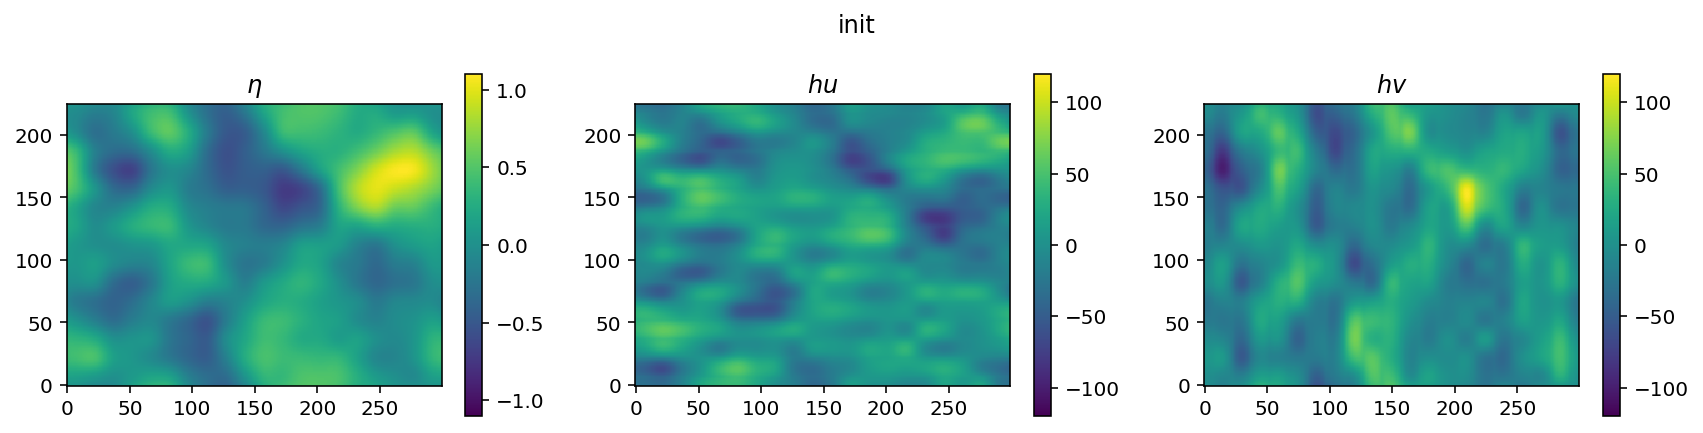

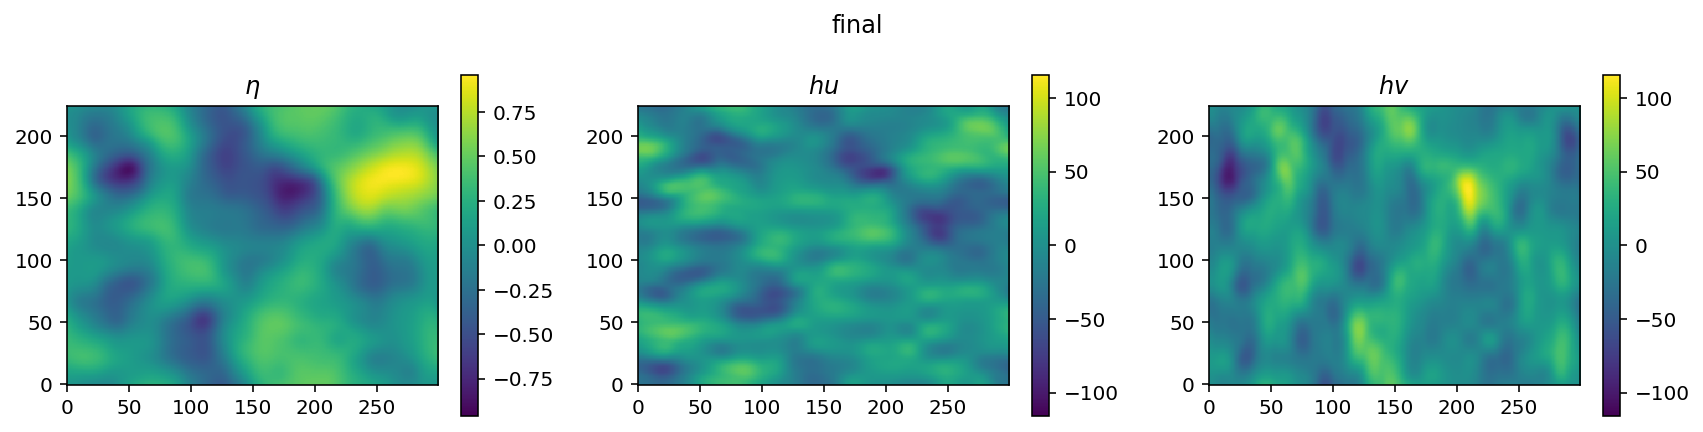

In [27]:
reload(CDKLM16)
soar_init_sim = CDKLM16.CDKLM16(**sim_args, **data_args)
soar_init_sim.setSOARModelError(**soar_args)

soar_init_sim.perturbState(q0_scale=100)
plotState(soar_init_sim, title="init")

soar_init_sim.step(1000, apply_stochastic_term=False)
plotState(soar_init_sim, title="final")

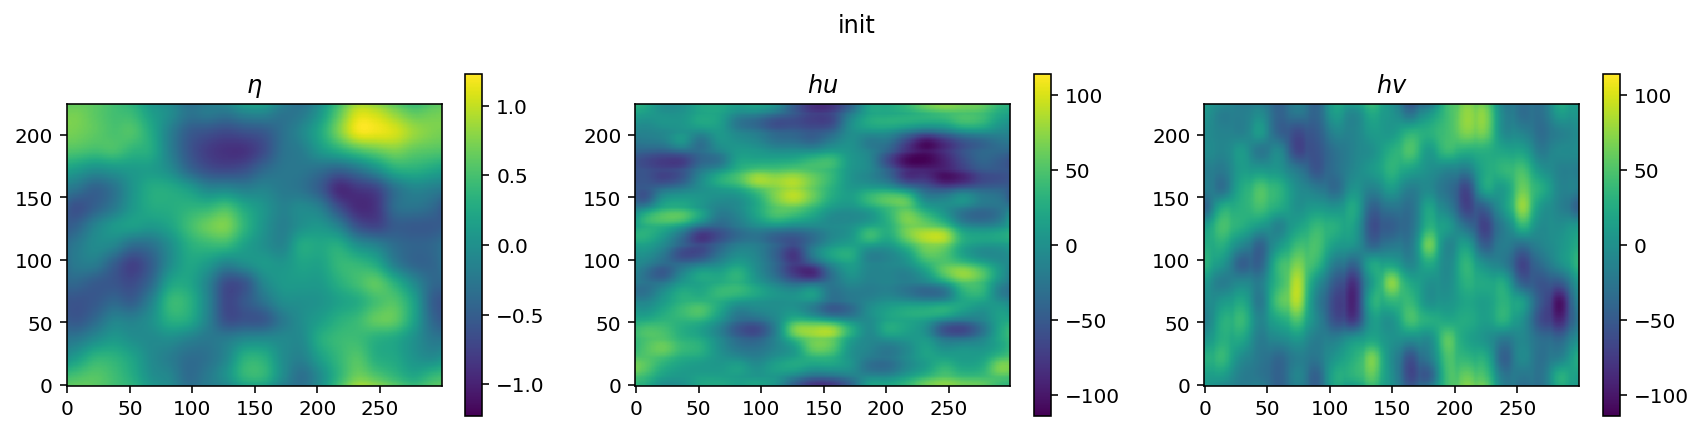

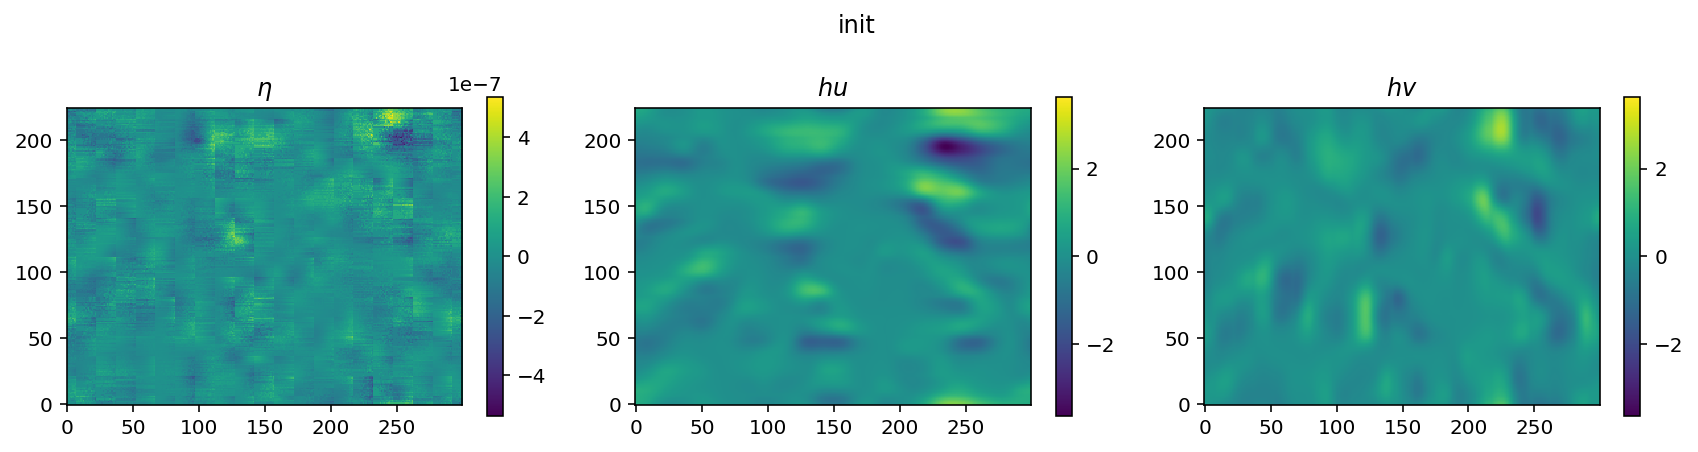

In [39]:
reload(CDKLM16)
soar_init_sim = CDKLM16.CDKLM16(**sim_args, **data_args)
soar_init_sim.setSOARModelError(**soar_args)

soar_init_sim.perturbState(q0_scale=100)
plotState(soar_init_sim, title="init")

#soar_init_sim.upload(data_args["eta0"], data_args["hu0"], data_args["hv0"])
#plotState(soar_init_sim, title="set to zero")

soar_init_sim.perturbState(perturbation_scale=-100, update_random_field=False)
plotState(soar_init_sim, title="init")




From lake at rest, add model error every timestep

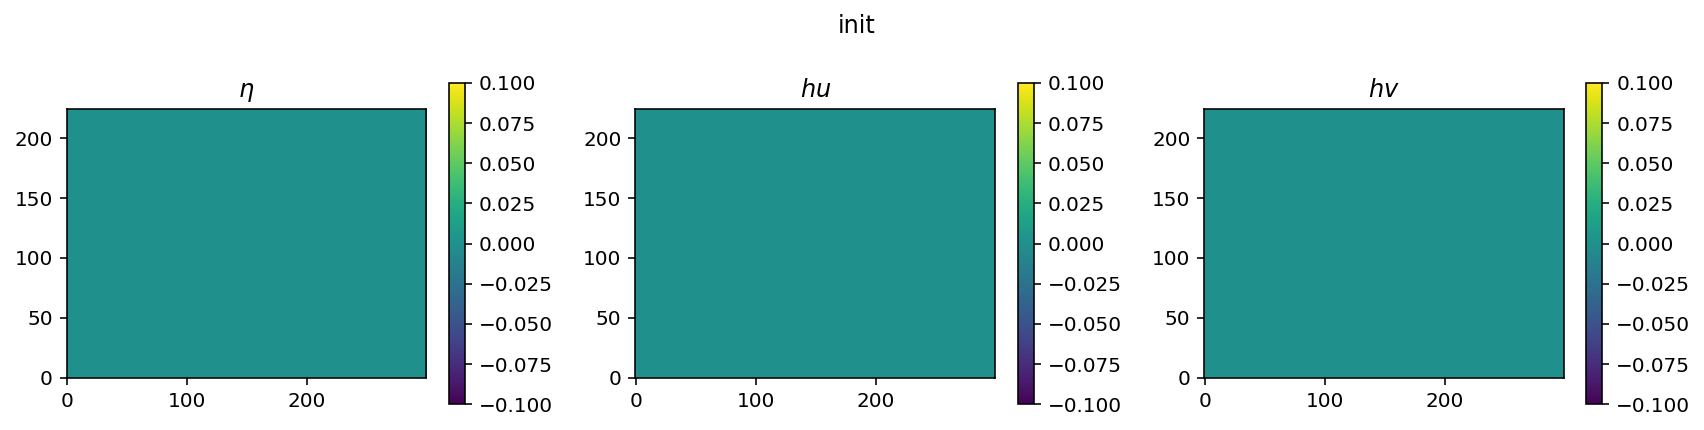

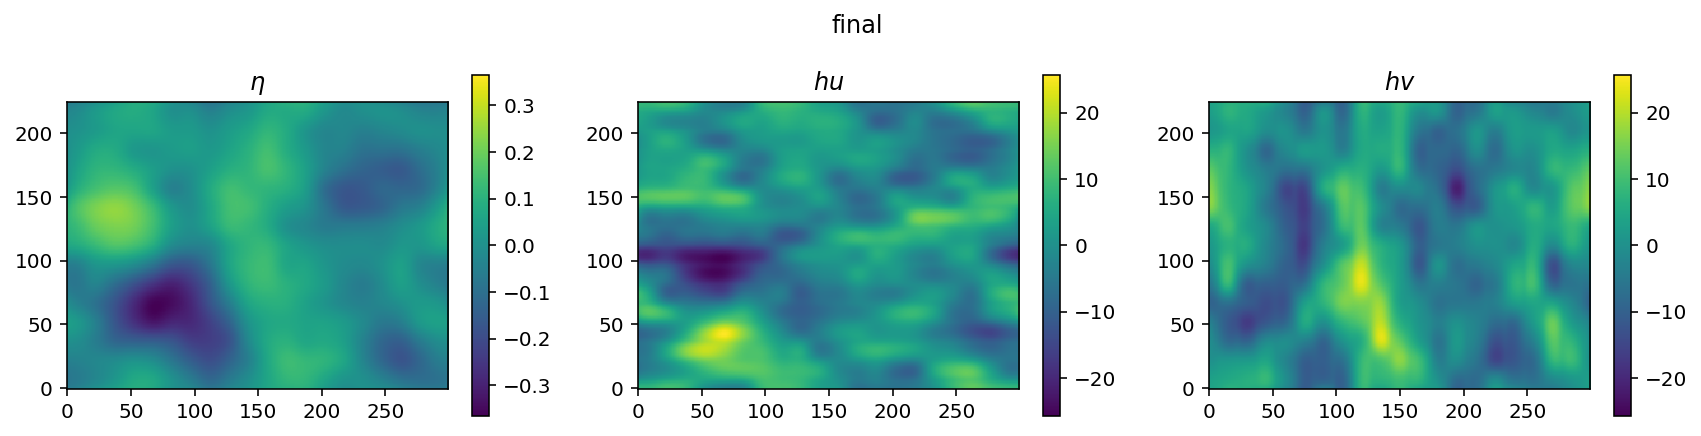

In [16]:
reload(CDKLM16)
soar_sim = CDKLM16.CDKLM16(**sim_args, **data_args)
soar_sim.setSOARModelError(**soar_args)

plotState(soar_sim, title="init")

soar_sim.step(1000) # apply_stochastic_term is true by default
plotState(soar_sim, title="final")

Apply model error at a specific time interval independent of sim.dt.

Note that the amplitude of the model error scales with $\sqrt{\Delta t}$, where $\Delta t$ is the interval between applying the model error.

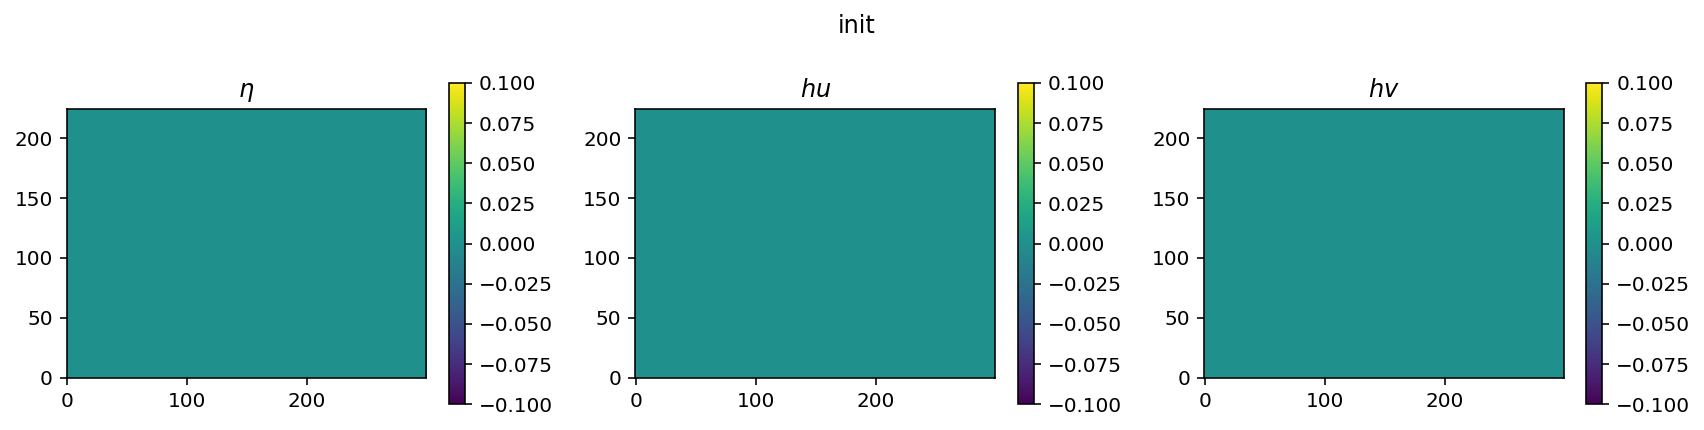

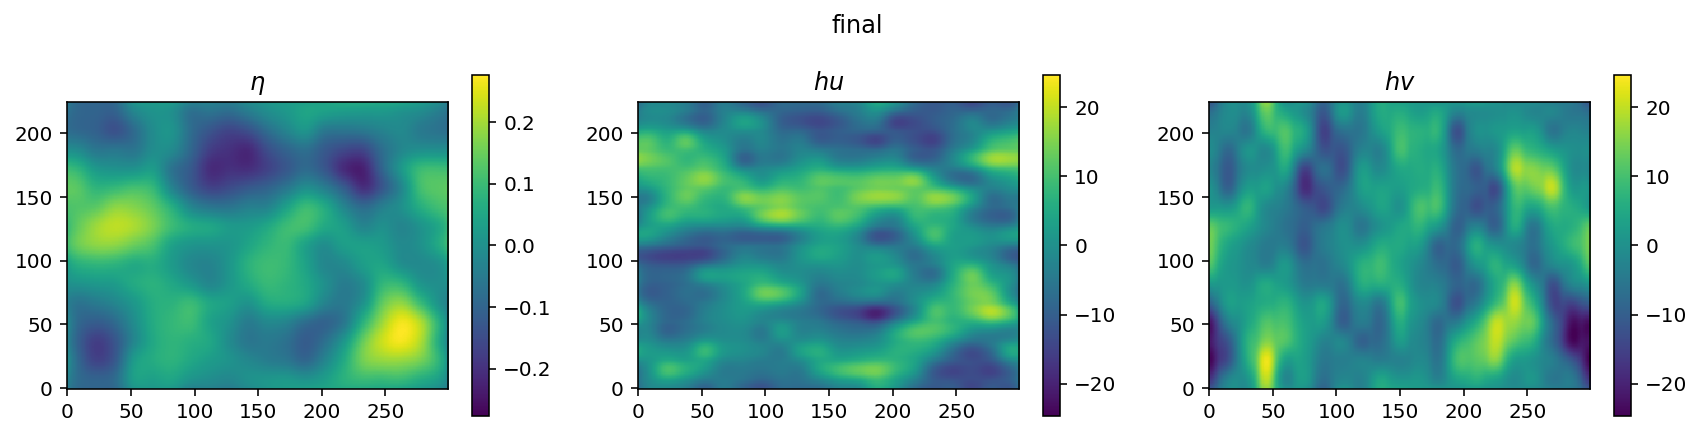

In [42]:
reload(CDKLM16)
soar_sim_largedt = CDKLM16.CDKLM16(**sim_args, **data_args, model_time_step=100)
soar_sim_largedt.setSOARModelError(**soar_args)

plotState(soar_sim_largedt, title="init")

soar_sim_largedt.step(1000) # apply_stochastic_term is true by default
plotState(soar_sim_largedt, title="final")

In [51]:
soar_sim_largedt.model_error.__class__

gpuocean.SWEsimulators.OceanStateNoise.OceanStateNoise

In [60]:

if str(soar_sim_largedt.model_error.__class__).find("OceanStateNoise") > -1: 
    print("hei")

hei
